# Exploring data with Python
This notebook is a copy of the [NHANES Survival I model notebook](https://github.com/slundberg/shap/blob/master/notebooks/tree_explainer/NHANES%20I%20Survival%20Model.ipynb) from the creators of SHAP, with sections added for data exploration. This dataset has a variety of medical data, and so should be nice and familiar to physicians. The SHAP creators have also provided an easy function to download the dataset, so you do not have to worry about getting a file yourself.


We'll be using Pandas, Pandas-summary,  TableOne, Matplotlib,  and SHAP to explore the data.


## Outline
Here's the basic plan:
1. Load data and look at it
1. Do some exploratory data analysis
  1. Get summary statistics for every column
  1. Make summary plots for every column
  1. Make Table 1, or a semblance of it
1. Train the model
1. Use SHAP to explore the model's predictions, including relationships between variables


## General Ideas

A few principles:
- I like to make things as general as possible, as often as possible. That way I can reuse code. 
  - For example, instead of manually selecting all of the numeric columns to make histograms, use a little bit of code to automatically detect which columns are numeric.
  - If the script is properly built, all you should have to do is clean the data to the point where you are comfortable creating a dataframe called "df", then let the code rock and roll on its own.
  - This also explains the `try/except` statements littered throughout - if one thing fails, we don't want the whole script to stop running. We'll make a log of what failed, so we can go back later and see if something is worth fixing or not.
  - The goal is to produce a whole grip of output that you can pick through at your leisure, to reveal places that would warrant a deeper dive. The images could also be optimized for publication, e.g. you may want to set your own number of bins for the histograms, but the automatic output for this code is surprisingly serviceable. 
- Prefer pdf images over all other types. They are infinitely scalable, have real text, and can be easily converted into jpg/png/tiff/whatever. Despite these advantages, they are much, much smaller on disk than rasterized images (jpg/png/etc.). At the end of this notebook you will have a zip file with tons of pdf images and csv files, all of which will likely amount to less than a megabyte.

# Setup
## Install missing libraries and import

Using `pip` with the `-q` option to silence the extra output.

In [1]:
!pip install shap -q
!pip install pandas-summary -q
!pip install tableone -q

     |████████████████████████████████| 235kB 5.0MB/s 


In [0]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from tableone import TableOne
import modality
import numpy as np
import sys
import os
import traceback # for error handling
import shutil 
# we're going to use shutil to make a zip file of all of our explorations
# so we can easily take it with us/email it to a colleague/etc.
%matplotlib inline

In [0]:
# A little function to save the exceptions (errors) to file
# and print them to the terminal.
# The only problem I can find with this function is that 
# Jupyter notebooks restart their numbering in every cell, 
# making it a little harder to find exactly where the error occurred.
# If you use it in a vanilla .py script, that problem disappears.

def exhandler(ex):
    exfile = open("exceptions.txt","a")
    print('#' * 80) # a line of `#` to make a clear delineation bw errors
    exfile.write(f"Error on line {sys.exc_info()[-1].tb_lineno}:")
    exfile.write(f"\n {str(ex)} \n")
    exfile.write(traceback.format_exc())
    print('#' * 80)
    exfile.close() 
    print(ex)
    print(traceback.format_exc())


## Load and clean data

In [0]:
# the SHAP "datasets" functions just grab csv files from the SHAP github account
# and read them into pandas dataframes

X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) 
# human readable feature values 
# - all they did was convert "Sex" from 1/0 to Female/Male

# the SHAP people split off the survival data for prediction. 
# Let's stick it back on for description
df = X_display.copy()
df["survival"] = y

# A little cleaning:
# Unnamed: 0 is a duplicate axis, drop it here
df.drop(["Unnamed: 0"], axis=1, inplace=True)

# The "Race" column was converted from discrete racial types into numbers
# I don't know which number corresponds to which race for sure,
# but based on frequency I'm guessing it's 
# the standard "White," "African American", "Other" schema.

df.replace({'Race': {1: "White", 2: "African_American", 3: "Other"}}, inplace=True)
df["Race"] = df["Race"].astype('category')

# The "Sex" column should also be categorical
df["Sex"] = df["Sex"].astype('category')

# Exploratory Data Analysis (EDA)

## Take a peek
I think the best way to start exploring data is to actually look at it. If you have a csv file, Excel doc, or whatever, open it up and poke around. One equivalent in Pandas is to load the data and call `dataset_name.head(x)`, with whatever number of rows you want to see in `(x)`. 

In [5]:
df.head(10)

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,survival
0,35.0,92.0,126.0,African_American,77.7,12.0,5.0,165.0,135.0,1.37,7.6,Female,142.0,323.0,41.8,5.8,31.109434,50.0,15.274658
1,71.0,78.0,210.0,African_American,77.7,37.0,4.0,298.0,89.0,1.38,6.4,Female,156.0,331.0,26.9,5.3,32.362572,78.0,11.586073
2,74.0,86.0,999.0,African_American,77.7,31.0,3.8,222.0,115.0,1.37,7.4,Female,170.0,299.0,38.5,8.1,25.388497,84.0,8.149087
3,64.0,92.0,385.0,White,77.7,30.0,4.3,265.0,94.0,1.97,7.3,Female,172.0,349.0,26.9,6.7,26.446610,80.0,-21.094292
4,32.0,70.0,183.0,African_American,77.7,18.0,5.0,203.0,192.0,1.35,7.3,Male,128.0,386.0,49.7,8.1,20.354684,58.0,-0.000000
5,40.0,78.0,297.0,African_American,77.7,24.0,4.0,173.0,121.0,1.71,6.7,Female,118.0,370.0,32.7,10.7,27.217201,40.0,-21.080594
6,53.0,76.0,461.0,White,77.7,2.0,4.3,276.0,135.0,1.74,7.6,Male,124.0,334.0,40.4,6.0,23.091823,48.0,-21.072374
7,36.0,66.0,423.0,White,77.7,11.0,4.2,160.0,107.0,1.69,6.3,Female,108.0,289.0,37.0,9.5,20.313169,42.0,-21.355251
8,49.0,86.0,385.0,White,77.7,34.0,4.3,326.0,85.0,1.62,7.3,Male,134.0,385.0,22.1,6.4,30.004222,48.0,-21.370091
9,31.0,90.0,461.0,White,77.7,4.0,4.3,172.0,104.0,1.39,6.0,Male,130.0,436.0,23.9,9.7,29.675734,40.0,-21.154566


## Pandas `.describe()`
The `data.describe()` function from Pandas is very powerful and easy to use. It summarizes the entire dataset, with means, medians,  quartiles, etc. Use the `include='all'` option to include numeric and categorical columns. Check the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) for more options. 

I'll also show you how to save the output of these functions to disk so you can play with them later. Most of the time, all you have to do is make a Pandas `DataFrame` from the output, then use the Pandas `to_csv` function to create a file that can be read in any text editor or spreadsheet program. 

If you're in Colab, you can also double click on the CSV file in the "Files" pane on the left and it will pull it up in its internal spreadsheet viewer.

In [6]:
# first make some directories to keep things clean

# top level directory, where we'll put everything
!mkdir -p exploratory_data_analysis

# move into that directory
os.chdir("exploratory_data_analysis")

# now make a directory for the summary files
!mkdir -p data_summaries

# and finally call `df.describe`
data_describe = pd.DataFrame(df.describe(include='all'))
data_describe.to_csv("data_summaries/data_describe.csv")

# If you are using Google Colab, 
# click the `>` on the left to expand the panel (if it's not already expanded), 
# then click on "Files" to see that you have the new folders and the .csv file, 
# which you can right click to download or double click to view.

# We'll call the function again just so we can see it in-line
df.describe(include='all')

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,survival
count,9932.000000,9874.000000,9932.000000,9932,9932.000000,9106.000000,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000,9932,9875.000000,9932.000000,9932.000000,8891.000000,9932.000000,9873.000000,9932.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,8091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6031,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,49.449054,83.281953,287.213049,NaN,54.880528,16.268285,4.365103,221.234837,101.117298,1.681307,7.104068,NaN,134.854481,362.604511,28.555910,7.451760,25.689771,51.575509,-8.138465
std,15.878425,13.291925,223.310410,NaN,14.600767,11.511728,0.331212,49.494473,37.211666,0.145905,0.508969,NaN,24.932032,58.993649,11.232671,2.292071,5.184155,18.299075,14.848999
min,25.000000,25.000000,2.000000,NaN,21.400000,1.000000,2.700000,53.000000,17.000000,0.820000,4.400000,NaN,80.000000,112.000000,3.200000,2.100000,12.585333,10.000000,-22.058676
25%,35.000000,74.000000,130.000000,NaN,45.000000,7.000000,4.200000,187.000000,75.000000,1.590000,6.800000,NaN,118.000000,322.000000,21.000000,6.000000,22.108338,40.000000,-20.103653
50%,48.000000,82.000000,233.000000,NaN,48.900000,14.000000,4.400000,217.000000,96.000000,1.680000,7.100000,NaN,130.000000,356.000000,27.200000,7.200000,24.928952,48.000000,-18.710502
75%,66.000000,90.000000,372.000000,NaN,57.600000,22.000000,4.600000,250.000000,122.000000,1.770000,7.400000,NaN,150.000000,396.000000,34.600000,8.600000,28.369043,60.000000,7.006450


## Pandas_summary
Pandas_summary is a nice package that extends Pandas' `df.describe()` method, sometimes overwhelmingly.

Here's their [GitHub page](https://github.com/mouradmourafiq/pandas-summary), which has examples and instructions.

In [7]:
from pandas_summary import DataFrameSummary

# first we initialize the DataFrameSummary
dfs = DataFrameSummary(df)

# `columns_stats` gives some useful data for each column, 
# saving you some function calls to find out, for example,
# how many unique values you have in each variable,
# how much is missing, or what kind of data each column contains
columns_stats = pd.DataFrame(dfs.columns_stats)
columns_stats.to_csv("data_summaries/data_summary.csv")
columns_stats.head(10)

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,survival
counts,9932,9874,9932,9932,9932,9106,9932,9932,9932,9932,9932,9932,9875,9932,9932,8891,9932,9873,9932
uniques,50,77,497,3,308,65,31,396,251,134,53,2,103,390,649,157,8986,108,6339
missing,0,58,0,0,0,826,0,0,0,0,0,0,57,0,0,1041,0,59,0
missing_perc,0%,0.58%,0%,0%,0%,8.32%,0%,0%,0%,0%,0%,0%,0.57%,0%,0%,10.48%,0%,0.59%,0%
types,numeric,numeric,numeric,categorical,numeric,numeric,numeric,numeric,numeric,numeric,numeric,bool,numeric,numeric,numeric,numeric,numeric,numeric,numeric


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,survival
mean,49.4491,83.282,287.213,NaN,54.8805,16.2683,4.3651,221.235,101.117,1.68131,7.10407,NaN,134.854,362.605,28.5559,7.45176,25.6898,51.5755,-8.13846
std,15.8784,13.2919,223.31,NaN,14.6008,11.5117,0.331212,49.4945,37.2117,0.145905,0.508969,NaN,24.932,58.9936,11.2327,2.29207,5.18416,18.2991,14.849
variance,252.124,176.675,49867.5,NaN,213.182,132.52,0.109701,2449.7,1384.71,0.0212882,0.259049,NaN,621.606,3480.25,126.173,5.25359,26.8755,334.856,220.493
min,25,25,2,NaN,21.4,1,2.7,53,17,0.82,4.4,NaN,80,112,3.2,2.1,12.5853,10,-22.0587
max,74,180,999,NaN,88.8,72,5.7,793,396,2.89,11.5,NaN,270,717,100,56,72.2181,170,21.4715


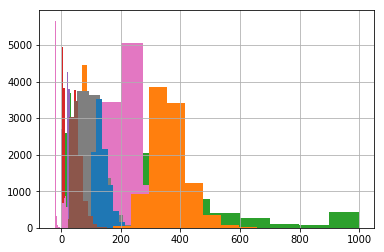

In [8]:
# this function gives a TON of data.
# We'll make a new dataframe, shove all the data into it,
# and save it to disk.
data_summary = pd.DataFrame()

for col in list(df):
  data_summary[col] = dfs[col]

data_summary.to_csv("data_summaries/data_summary_extended.csv")
# change 5 to some big number like 100 to see all of the output.
data_summary.head(5)
# It also automatically plots histograms, 
# which aren't super useful when I generate them this way 
# because there are many overlapping figures and they aren't labeled.

## Table One

In most biomedical research papers, the first table describes the cohort under consideration. The main idea is to allow the reader to quickly grasp the key features of the cohort and allow for easy comparison of any significant subgroups within the data. One common use is to compare two cohorts in a randomized study, to see if the groups are more dissimilar than one would expect based on chance (though the utility of this approach is debated!).

Making Table One can be a bit of a beast. It can include a lot of data and a lot of math, which would be tiresome and error-prone to do by hand. The Python package TableOne automates the process, allows for several versions of the output, and give you enough control to make your statistician happy. [See their website](https://pypi.org/project/tableone/) for more documentation, examples, and an academic paper they wrote explaining the package and its uses.

I should also note that this packge will get you >90% of the way there. Final tweaks to formatting will have to be done using Pandas, Excel, or whatever you like for that kind of thing.

This dataset does not have treatment groups. However, we can get the basic idea of how the function works by grouping the cohort by any available categorical variable. Using the TableOne package this way is also an easy (and, dare I say, fun) way to explore your data and find relationships you may not have otherwise noticed.

 ### Explore the options
 With a package like this, I like to list out all of the possible options first. This helps me decide how to structure the data for input, and also reveals the possibilities of the output.

You should also note that you can skip most of this and try the defaults with something like:

```python
mytable = TableOne(df)
print(mytable)
```

```python
    mytable = TableOne(
        data, # the data we will pass in
        groupby=groupby, # if we want to stratify the table (say, by tx group)
        columns=columns, # which variables of `data` do we want to analyze?
        # if we want all of them, leave `columns` blank
        categorical=categorical, # which variables are categorical?
        nonnormal=nonnormal, # which variables are non-normally distributed?
        labels=labels, # do we want to give new names to the variables?
        label_suffix=True, # Add suffix to label (e.g. "mean (SD); median [Q1,Q3], n (%)")
        decimals=decimals, # how many decimal places do we want to report for each variable?
        isnull=False, # do we want to print how many values are missing of a given variable?
        pval=False, # do we want to print p-values?,
        pval_adjust='None' # do we want to adjust p-values for multiple testing? If so, how?
        ddof=1, # how many degrees of freedom for standard deviation calculations?
        sort=False, # do we want to sort the columns alphabetically, or by our own order?
        limit=100, # do we want to limit the report to the top N most frequent categories?
        remarks=True, # do we want TableOne to tell us about our stats and any problems?
    )
```

### Make it so
Now that we know all of the options, let's set up the input.

We will define columns, groupbys, categorical variables, 
nonnormal variables, labels, and the desired number of decimal places.

In [9]:
############################# columns ##########################################
# Make a master list of columns to convert into TableOne
# Select all of the available columns:
columns = list(df)
# Or pick by hand:
# columns = ["Age","Race","Sex", "TIBC", "TS"]
# The order you put these in will determine the order in the final table



############################# groupby ##########################################
# I'm going to show you a trick with the "groupby" argument
# to allow you to loop over all possible groupings of categorical variables
# and make a table for each.
# Set it up here as plural, `groupbys`,
# and let pandas find all the categorical columns:
groupbys = list(df.select_dtypes(include='category'))
# make sure you are only selecting columns that exist
# in your master list
groupbys = list(set(groupbys) & set(columns))
# print(groupbys)
# Or pick by hand
# groupby = ["Sex"]



############################# categories #######################################
# Notice that this code is the exact same as above
categorical = list(df.select_dtypes(include='category'))
categorical = list(set(categorical) & set(columns))
# You can also select the categorical columns by hand,
# categorical = ["Sex", "Race"]




############################# normality ########################################
# TableOne will perform D’Agostino’s K^2 test to check for normality
# and let you know which columns it thinks you should look at again.
# We can use the same idea to automatically select nonnormal columns beforehand,
# or you can define a list yourself, e.g.: nonnormal = ["Age", "Diastolic BP"]
# You could use a similar setup to test for normality for each variable
# using whatever statistical tool you want - 
# see https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
# for a nice overview of several built-in options

from scipy import stats
# start an empty list
nonnormal = []
# using standard alpha of 0.05 - change to whatever you like
alpha = 0.05

for x in list(df):
  try:
    stat,p = stats.normaltest(df[x].values, nan_policy='omit') # omit missing
    
    if p > alpha:
        # uncomment out these print statements for more verbose output
#       print(f"{x} appears to fit a Gaussian distribution")
#       print(f"p={p} \n")
      print("")
      
    else:
      nonnormal.append(x)
#       print(f"{x} appears to be non-normally distributed")
#       print(f"p={p} \n")
      
  except:
#     print(f"Could not determine normality for {x} \n")
    print("")

# finally, make sure the nonnormal list only includes
# columns that you chose in "columns"
nonnormal = list(set(nonnormal) & set(columns))
# if you'd like, print out the new list of nonnormal items:
# print(nonnormal)



############################# labels ###########################################
# Labels is a dictionary, with the old variable name on the left
# and the one you want printed on the right.
# If you want to leave them alone, leave it blank:
# labels = {}
# Otherwise, provide a dictionary:
labels = {"TIBC": "Total Iron Binding Capacity", "TS": "Transferrin Saturation"}



############################# decimal places ###################################
# If you want to use the default, leave this empty:
# decimals = {}
# Otherwise, provide a dictionary:
decimals = {"Age": 0, 'Sedimentation rate': 0, 'Diastolic BP': 0}

In [23]:
# Here's some secret sauce for exploratory data analysis:
# make a loop to output a new TableOne for every category

!mkdir -p tables_one

for groupby in groupbys:
  
  mytable = TableOne(
      df, # the data we will pass in
      groupby=groupby, # if we want to stratify the table (say, by tx group)
      columns=columns, # which variables of `data` do we want to analyze?
      # if we want all of them, leave `columns` blank
      categorical=categorical, # which variables are categorical?
      nonnormal=nonnormal, # which variables are non-normally distributed?
      labels=labels, # do we want to give new names to the variables?
      label_suffix=True, # Add suffix to label (e.g. "mean (SD); median [Q1,Q3], n (%)")
      decimals=decimals, # how many decimal places do we want to report for each variable?
      isnull=False, # do we want to print how many values are missing of a given variable?
#       pval=True, # do we want to print p-values?,
#       pval_adjust='bonferroni', # do we want to adjust p-values for multiple testing? If so, how?
#       ddof=1, # how many degrees of freedom for standard deviation calculations?
#       sort=False, # do we want to sort the columns alphabetically, or by our own order?
#       limit=5, # do we want to limit the report to the top N most frequent categories?
      remarks=True, # do we want TableOne to tell us about our stats and any problems?
  )
  
  # take a look
#   print(mytable)
  

  # Save table to LaTeX (for the nerds), HTML (for easy viewing), and CSV (for easy export)
  mytable.to_latex(f'tables_one/tableone_{groupby}.tex')
  mytable.to_html(f'tables_one/tableone_{groupby}.html')
  mytable.to_csv(f'tables_one/tableone_{groupby}.csv')

  
  # make a non-grouped version:
nongrouped = TableOne(
     df, # the data we will pass in
#      groupby=groupby, # if we want to stratify the table (say, by tx group)
     columns=columns, # which variables of `data` do we want to analyze?
     # if we want all of them, leave `columns` blank
     categorical=categorical, # which variables are categorical?
     nonnormal=nonnormal, # which variables are non-normally distributed?
     labels=labels, # do we want to give new names to the variables?
     label_suffix=True, # Add suffix to label (e.g. "mean (SD); median [Q1,Q3], n (%)")
     decimals=decimals, # how many decimal places do we want to report for each variable?
     isnull=False, # do we want to print how many values are missing of a given variable?
#      pval=True, # do we want to print p-values?,
#      pval_adjust='bonferroni', # do we want to adjust p-values for multiple testing? If so, how?
#      ddof=1, # how many degrees of freedom for standard deviation calculations?
#      sort=False, # do we want to sort the columns alphabetically, or by our own order?
#      limit=5, # do we want to limit the report to the top N most frequent categories?
     remarks=True, # do we want TableOne to tell us about our stats and any problems?
 )
  
nongrouped.to_latex(f'tables_one/tableone_nongroupby.tex')
nongrouped.to_html(f'tables_one/tableone_nongroupby.html')
nongrouped.to_csv(f'tables_one/tableone_nongroupby.csv')
# print(nongrouped)

# mytable = pd.DataFrame(mytable)
# mytable["Overall"] = nongrouped["overall"]
print(mytable)

                                                                   Grouped by Sex                     
                                                                           Female                 Male
variable                                    level                                                     
n                                                                            6031                 3901
Age, median [Q1,Q3]                                                    44 [33,65]           54 [39,67]
Diastolic BP, median [Q1,Q3]                                           80 [72,90]           84 [78,92]
Poverty index, median [Q1,Q3]                                 219.0 [124.0,351.0]  248.0 [143.0,385.0]
Race, n (%)                                 African_American          1094 (18.1)           641 (16.4)
                                            Other                        56 (0.9)             50 (1.3)
                                            White                     488

In [32]:
# Pull out and plot possibly multimodal values

multimodal = []
# using standard alpha of 0.05 - change to whatever you like
alpha = 0.05

for x in list(df):
  try:
    p = modality.hartigan_diptest(df[x].values)
    
    if p > alpha:
        # uncomment out these print statements for more verbose output
#       print(f"{x} appears to not be multimodal")
#       print(f"p={p} \n")
      print("")
      
    else:
      multimodal.append(x)
#       p < 0.05 suggests possible multimodality
#       print(f"{x} appears to be multimodal")
#       print(f"p={p} \n")
      
  except:
    print(f"Could not determine modality for {x} \n")
    print("")

    
!mkdir -p multimodal

for feature in multimodal:
  try:
#     print(feature, "\n")
    df[feature].dropna().plot.kde(figsize=[12,8])
    plt.legend([feature])
    plt.tight_layout()
    plt.savefig(f"multimodal/multimodal_{feature}.pdf", transparent=True)
#     plt.show()
    plt.close()
  except:
    print(f"Could not make modality plot for {feature} \n")



Could not make modality plot for Race 

Could not make modality plot for Sex 



In [33]:
# Pull out and plot possible outliers

near_outliers = []
far_outliers = []

near_thresh = 1.5
far_thresh = 3

!mkdir -p outliers

for x in list(df):
  try:
print(x, "\n")
       vals = df[x].values[~np.isnan(df[x].values)]
       try:
            q1, q3 = np.percentile(vals, [25, 75])
            iqr = q3 - q1
            
            low_bound_near = q1 - (iqr * near_thresh)
            high_bound_near = q3 + (iqr * near_thresh)
            near_outliers = near_outliers.append(np.where((vals > high_bound_near) | (vals < low_bound_near)))
            
            low_bound_far = q1 - (iqr * far_thresh)
            high_bound_far = q3 + (iqr * far_thresh)
            far_outliers = far_outliers.append(np.where((vals > high_bound_far) | (vals < low_bound_far)))
        except:
            print(f"Outlier detection failed for {x}")
            print("")
      
      data[x].boxplot(whis=3)
      plt.tight_layout()
      plt.savefig(f"outliers/outlier_{x}.pdf", transparent=True)
#     plt.show()
      plt.close()
  except:
    print(f"Could not make boxplot for {x}")
    print("")

IndentationError: ignored

## Let's plot some histograms. 
Everybody loves histograms.

Depending on the size of your dataset, this can take a while.
Feel free to skip this cell for now.

If you want a primer on Matplotlib histograms, check out [Corey Schafer's YouTube videos ](https://www.youtube.com/watch?v=XDv6T4a0RNc) and [code snippets](https://github.com/CoreyMSchafer/code_snippets/blob/master/Python/Matplotlib/06-Histograms/finished_code.py). His whole Matplotlib series is great, the best available as of mid-2019.

For an extra goodie, scroll down to the bottom of the notebook and I'll show you how to download a YouTube playlist using Python, with Schafer's Matplotlib playlist as an example.

In [11]:
# make a histogram directory
!mkdir -p histograms

# select a pretty default plotting style
plt.style.use('fivethirtyeight')

# we're going to wrap this in a "try" statement 
# so if any of them fail it will inform us and move on to the next one
# we're also going to select only numeric columns
for col in list(df.select_dtypes(include=[np.number]).columns.values):
  try:
#     print(col)
    plt.hist(df[col], edgecolor='black')
    plt.title(f"{col}")
    # find the median of each column
    median = df[col].median()
    # pick a color for the line
    color = '#fc4f30'
    # plot a red vertical line showing the median value
    plt.axvline(median, color=color, label='Median', linewidth=2)
    # I don't know why `tight_layout()` isn't the default. It's much prettier.
    plt.tight_layout()
    # Add the `.pdf` extension to get a pdf, 
    # and add `transparent=True` to make the background transparent
    # (useful for making combined figures later)
    plt.savefig(f"histograms/{col}_hist.pdf", transparent=True)
    plt.close()
  except Exception as ex:
    print(f"No histogram made for {col}")
    exhandler(ex)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


# NHANES I Survival Model

This is a cox proportional hazards model on data from <a href="https://wwwn.cdc.gov/nchs/nhanes/nhanes1">NHANES I</a> with followup mortality data from the <a href="https://wwwn.cdc.gov/nchs/nhanes/nhefs">NHANES I Epidemiologic Followup Study</a>. It is designed to illustrate how SHAP values enable the interpretion of XGBoost models with a clarity traditionally only provided by linear models. We see interesting and non-linear patterns in the data, which suggest the potential of this approach. Keep in mind the data has not yet been checked by us for calibrations to current lab tests and so you should not consider the results as actionable medical insights, but rather a proof of concept. 

Note that support for Cox loss and SHAP interaction effects were only recently merged, so you will need the latest master version of XGBoost to run this notebook.

## Create XGBoost data objects

This uses a pre-processed subset of NHANES I data available in the SHAP datasets module.

In [0]:
xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)






## Train XGBoost model

In [13]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:7.26934
[1000]	test-cox-nloglik:6.55588
[2000]	test-cox-nloglik:6.48688
[3000]	test-cox-nloglik:6.47231
[4000]	test-cox-nloglik:6.46993
[5000]	test-cox-nloglik:6.47147
[6000]	test-cox-nloglik:6.47407
[7000]	test-cox-nloglik:6.47613
[8000]	test-cox-nloglik:6.47911
[9000]	test-cox-nloglik:6.48227
[9999]	test-cox-nloglik:6.48552


In [14]:
# train final model on the full data set
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:8.88081
[1000]	test-cox-nloglik:8.1673
[2000]	test-cox-nloglik:8.07806
[3000]	test-cox-nloglik:8.03906
[4000]	test-cox-nloglik:8.01412
[4999]	test-cox-nloglik:7.99296


## Check Performance

The C-statistic measures how well we can order people by their survival time (1.0 is a perfect ordering).

In [15]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if labels[j] > 0 and abs(labels[i]) > labels[j]:
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

# see how well we can order people by survival
c_statistic_harrell(model_train.predict(xgb_test, ntree_limit=5000), y_test)

0.8356854248404286

# Explain the model's predictions on the entire dataset

In [0]:
shap_values = shap.TreeExplainer(model).shap_values(X)

### SHAP Summary Plot

The SHAP values for XGBoost explain the margin output of the model, which is the change in log odds of dying for a Cox proportional hazards model. We can see below that the primary risk factor for death according to the model is being old. The next most powerful indicator of death risk is being a man.

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

In [0]:
!mkdir -p shap_images

try:
  shap.summary_plot(shap_values, X, show=False)
  plt.tight_layout()
  plt.savefig("shap_images/shap_summary.pdf", transparent=True)
  plt.close()
except Exception as ex:
    exhandler(ex)

### SHAP Dependence Plots

While a SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. Note that the row of a SHAP summary plot results from projecting the points of a SHAP dependence plot onto the y-axis, then recoloring by the feature itself.

Below we give the SHAP dependence plot for each of the NHANES I features, revealing interesting but expected trends. Keep in mind the calibration of some of these values can be different than a modern lab test so be careful drawing conclusions.

### Beau's Note: 
The SHAP people did this one at a time, which is cool. I'll show you how to do it all in one fell swoop and save the images to file. Note  one of the drawbacks of automation: the SHAP people set custom parameters for many of the plots, and we're just letting Matplotlib select its own values. Most of the time this is totally fine.

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


KeyboardInterrupt: ignored

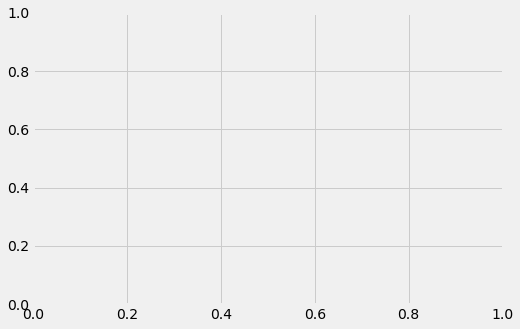

In [18]:
# Beau's lazy version
!mkdir -p shap_images/shap_dependence

for col in list(X):
  try:
    shap.dependence_plot(f"{col}", shap_values, X, show=False)
    plt.tight_layout()
    plt.savefig(f"shap_images/shap_dependence/shap_dependence_{col}.pdf", transparent=True)
    plt.close()
  except Exception as ex:
    exhandler(ex)

In [0]:
# we pass "Age" instead of an index because dependence_plot() will find it in X's column names for us
# Systolic BP was automatically chosen for coloring based on a potential interaction to check that 
# the interaction is really in the model see SHAP interaction values below
try:
  shap.dependence_plot("Age", shap_values, X, show=False)
except Exception as ex:
    exhandler(ex)

In [0]:
# Beau's note:
# there were some of the SHAP plots that didn't work out of the box, so I commented them out.
# for most of them, we made our own anyway

# we pass display_features so we get text display values for sex
# shap.dependence_plot("Sex", shap_values, X, display_features=X_display)

In [0]:
# setting show=False allows us to continue customizing the matplotlib plot before displaying it
shap.dependence_plot("Systolic BP", shap_values, X, show=False)
pl.xlim(80,225)
pl.show()

In [0]:
shap.dependence_plot("Poverty index", shap_values, X)

In [0]:
shap.dependence_plot("White blood cells", shap_values, X, display_features=X_display, show=False)
pl.xlim(2,15)
pl.show()

In [0]:
shap.dependence_plot("BMI", shap_values, X, display_features=X_display, show=False)
pl.xlim(15,50)
pl.show()

In [0]:
# shap.dependence_plot("Serum magnesium", shap_values, X, show=False)
# pl.xlim(1.2,2.2)
# pl.show()

In [0]:
shap.dependence_plot("Sedimentation rate", shap_values, X)

In [0]:
# shap.dependence_plot("Serum protein", shap_values, X)

In [0]:
# shap.dependence_plot("Serum cholesterol", shap_values, X, show=False)
# pl.xlim(100,400)
# pl.show()

In [0]:
shap.dependence_plot("Pulse pressure", shap_values, X)

In [0]:
# shap.dependence_plot("Serum iron", shap_values, X, display_features=X_display)

In [0]:
shap.dependence_plot("TS", shap_values, X)

In [0]:
shap.dependence_plot("Red blood cells", shap_values, X)

## Compute SHAP Interaction Values

See the Tree SHAP paper for more details, but briefly, SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented in the latest version of XGBoost with the pred_interactions flag. With this flag XGBoost returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [0]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.iloc[:2000,:])

### SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

In [0]:
try:
  shap.summary_plot(shap_interaction_values, X.iloc[:2000,:], show=False)
  plt.tight_layout()
  plt.savefig("shap_images/shap_interaction_summary.pdf", transparent=True)
  plt.close()
except Exception as ex:
    exhandler(ex)

shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

In [0]:
# Beau's lazy version - plot the main effects for each column
# and save the pictures to disk.
# Notice that there's a problem when it tries to plot "Sex", 
# but it keeps on chugging along anyway.
!mkdir -p shap_images/shap_self_dependence

for col in list(X):
  try:
    shap.dependence_plot((f"{col}",f"{col}"),
                         shap_interaction_values, X.iloc[:2000,:], 
                         display_features=X_display.iloc[:2000,:], 
                         show=False)
    plt.tight_layout()
    plt.savefig(f"shap_images/shap_self_dependence/shap_self_dependence_{col}.pdf", transparent=True)
    plt.close()
  except Exception as ex:
    print("")
    print(f"{col}")
    print("")
    exhandler(ex)

shap.dependence_plot(
    ("Age", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

Now we plot the interaction effects involving age. These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above. The plot below involving age and sex shows that the sex-based death risk gap varies by age and peaks at age 60.

In [0]:
shap.dependence_plot(
    ("Age", "Sex"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [0]:
shap.dependence_plot(
    ("Age", "Systolic BP"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [0]:
shap.dependence_plot(
    ("Age", "White blood cells"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [0]:
shap.dependence_plot(
    ("Age", "Poverty index"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [0]:
shap.dependence_plot(
    ("Age", "BMI"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [0]:
# shap.dependence_plot(
#     ("Age", "Serum magnesium"),
#     shap_interaction_values, X.iloc[:2000,:],
#     display_features=X_display.iloc[:2000,:]
# )

Now we show a couple examples with systolic blood pressure.

In [0]:
shap.dependence_plot(
    ("Systolic BP", "Systolic BP"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [0]:
shap.dependence_plot(
    ("Systolic BP", "Age"),
    shap_interaction_values, X.iloc[:2000,:],
    display_features=X_display.iloc[:2000,:]
)

In [0]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.tight_layout()
pl.savefig("shap_images/shap_interaction_summary_big.pdf", transparent=True)
pl.show()
pl.close()


# Zip it up!

We'll go back up one directory, then make a zip file containing everything under `exploratory_data_analysis`. 

You can then easily download all of your work and take it with you.

Because we preferred pdf images where possible, the zip file should be small or modest in size. Native PDF images produced by Matplotlib are "vector" images, and so are also infinitely scalable, generally speaking, making them look much better than jpg or png files with much larger footprints.

In [0]:
os.chdir("..") # go up one directory
shutil.make_archive("exploratory_data_analysis", 'zip', "exploratory_data_analysis")
os.chdir("exploratory_data_analysis") # go back, in case we want to do some other stuff later

# Extra goodie
I use YouTube constantly for learning things. 

Youtube-DL is a Python library that makes this much easier. I use it on my phone to download videos so I don't have to worry about buffering or using mobile data, then use the video as a sort of podcast I can listen to while doing dishes or whatever. It's also really nice for instructional videos you will reference often. 

Of course you can use it for more nefarious purposes, but I think PBS and Mr. Rogers would approve of this use-case (note: it is not illegal, but does violate the YouTube terms of service. Also, YouTubers make almost no money from video views until they get up into the superstar musician range - if you like someone's content and want to support them, Patreon or another platform is the way to go). 

I included the links to two favorites below, the Matplotlib course from Corey Schafer and the fastai course from Jeremy Howard and associates. Comment out the last lines to download these playlists, then zip them up to take home. (At the very end is some silliness to tell you how big the zip file is before you download it.)

In [0]:
!pip install youtube-dl -q
os.chdir("..") # go up one directory
!mkdir -p yt_vids

from __future__ import unicode_literals
import youtube_dl

ydl_opts = {
    'outtmpl': 'yt_vids/%(title)s.%(ext)s',
}

schafer_plt = 'https://www.youtube.com/playlist?list=PL-osiE80TeTvipOqomVEeZ1HRrcEvtZB_'
fastai = 'https://www.youtube.com/playlist?list=PLfYUBJiXbdtSIJb-Qd3pw0cqCbkGeS0xn'

# with youtube_dl.YoutubeDL(ydl_opts) as ydl:
#     ydl.download([schafer_plt])
    
# with youtube_dl.YoutubeDL(ydl_opts) as ydl:
#     ydl.download([fastai])
    
# shutil.make_archive("yt_vids", 'zip', "yt_vids")

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

# print("yt_vids zip size:")
# print(humansize(os.path.getsize("yt_vids.zip")))
print("EDA zip size:")
print(humansize(os.path.getsize("exploratory_data_analysis.zip")))
os.chdir("exploratory_data_analysis")